# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 05.10.2023

Мягкий дедлайн: 23:59MSK 18.10.2023

Жесткий дедлайн: 23:59MSK 22.10.2022

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: 12.5.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium

In [2]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [4]:
!wget  -O 'train.csv' -q 'https://www.dropbox.com/s/en5f9nhn915cnkf/_train.csv?dl=0'

In [5]:
train = pd.read_csv('train.csv')

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

Удалим dropoff_datetime.

In [6]:
train = train.drop(['dropoff_datetime'], axis = 1)

 Преобразуем даты в datetime-объекты.

In [7]:
train['pickup_datetime']= pd.to_datetime(train['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

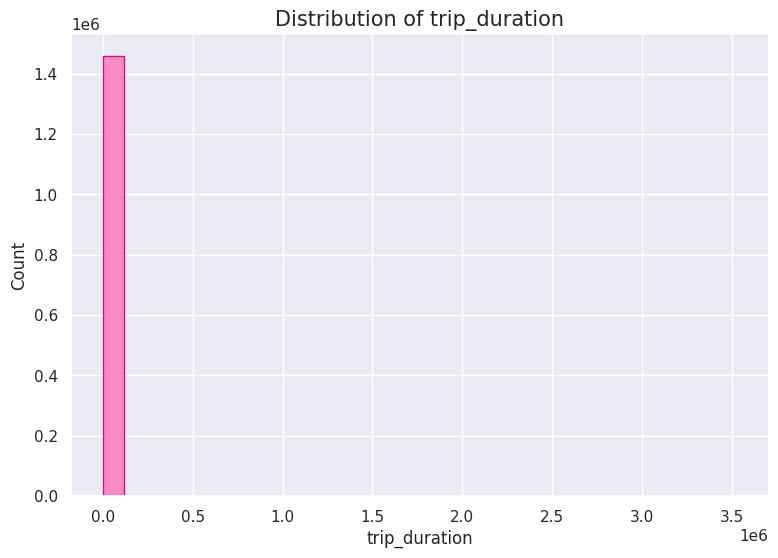

In [8]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_title('Distribution of trip_duration', fontsize=15)
sns.histplot(train.trip_duration,
             bins=30,
             ax=ax,
             color='hotpink',
             edgecolor='mediumvioletred');

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

В столбце с целевой переменной много выбросов, из-за этого распределение выглядит странно.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

RMSLE - это робастный метод, то есть он направлен на снижение влияния выбросов, в отличие от RMSE, который к ним довольно чувствителен. Как понятно из гистограмы, выбросов тут много, так что использовать RMSLE тут логичнее.

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.


**Доказательство**: $$\text{RMSE}(X, \hat{y}, \hat{a}) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y_i} - \hat{a(x_i)}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} = \text{RMSLE}(X, y, a)$$


Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

Добавим колонку log_trip_duration.

In [9]:
train['log_trip_duration'] = np.log1p(train['trip_duration'])

Построим график.

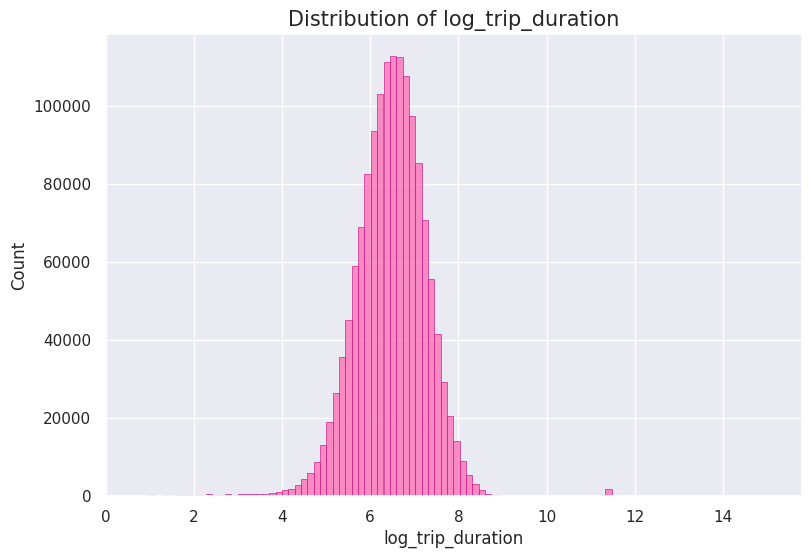

In [10]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_title('Distribution of log_trip_duration', fontsize=15)
sns.histplot(train.log_trip_duration,
             bins=100,
             ax=ax,
             color='hotpink',
             edgecolor='mediumvioletred');

И удалим колонку.

In [11]:
train = train.drop(['trip_duration'], axis = 1)

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [12]:
def rmsle(log1p_y_true, log1p_y_pred):
    error = np.sqrt(np.mean(np.square(log1p_y_pred - log1p_y_true)))
    return error
    raise NotImplementedError

rmsle_best_const = rmsle(train['log_trip_duration'], np.mean(train['log_trip_duration']))

assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

Создадим в 'train' колонку 'year_day'

In [13]:
train['year_day'] = train['pickup_datetime'].dt.date

Создадим датафрейм 'days' для простоты.

In [14]:
days = train.groupby(train['year_day']).id.count().reset_index().dropna()

Из-за того, что дней у нас здесь много, sns.countplot использовать не очень удобно. Лучше сделать heatmap.

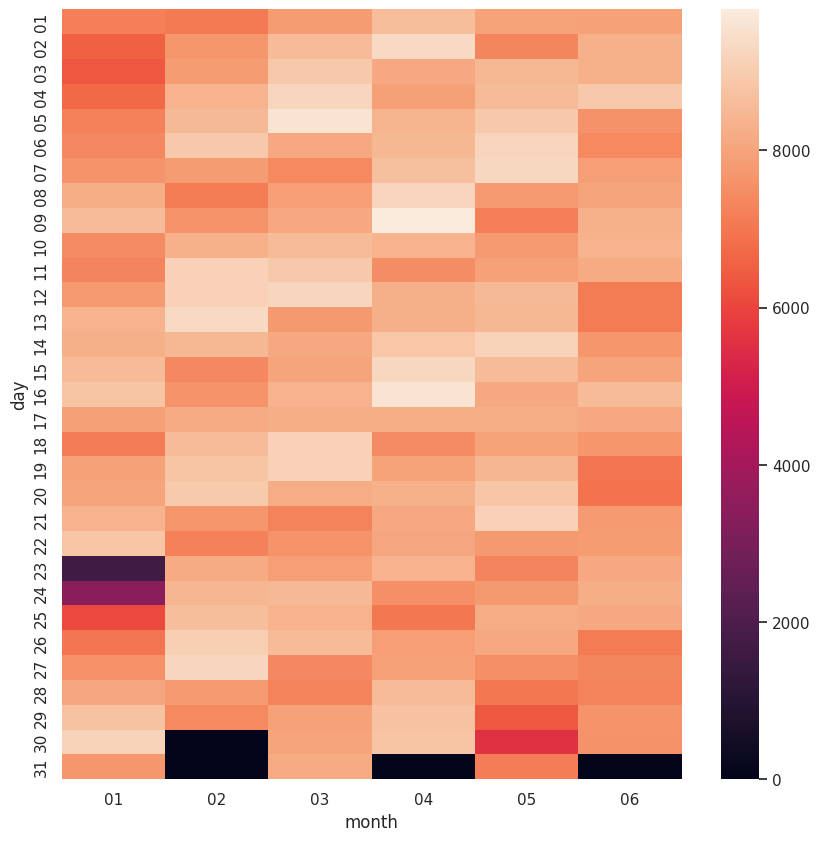

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
days['year_day'] = pd.to_datetime(days['year_day'])
days['month'] = days.year_day.dt.month.astype(str).str.zfill(2)
days['day'] = days.year_day.dt.day.astype(str).str.zfill(2)
pivot = days.pivot_table(index="day", columns="month", values="id", aggfunc="sum").fillna(0)
sns.heatmap(pivot)
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Как видно из графика, спад произошел с 23 января по 24 января, когда в Нью-Йорке были очень сильные снегопады, и машины практически не ездили. А также 30 мая, когда там был сильнейший ливень.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

График зависимости количества поездок от часов в сутках.

Добавим в 'train' колонку 'hour'.

In [16]:
train['hour'] = train['pickup_datetime'].dt.hour

Тоже для упрощения создаем датафрейм hours.

In [17]:
hours = train.groupby(train['hour']).id.count().reset_index().dropna()

И рисуем график

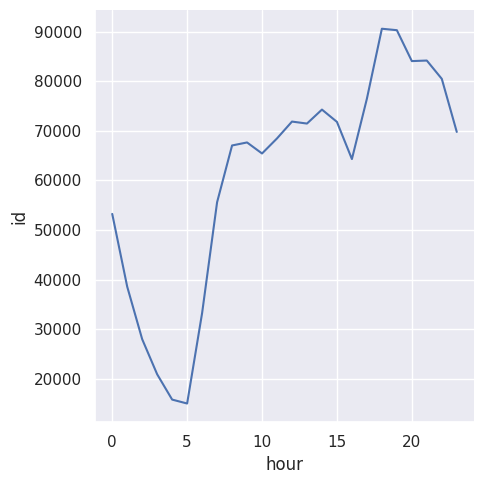

In [18]:
sns.relplot(data=hours, x='hour', y="id", kind="line")

График зависимости количества поездок от дня недели.

Добавим в train колонку 'w_day'.

In [19]:
train['w_day'] = train['pickup_datetime'].dt.strftime('%w')

Создаем датафрейм 'w_day' и меняем номера дней недели на их названия.

In [20]:
w_day = train.groupby([train['w_day']]).id.count().reset_index().dropna()
w_day['pickup_datetime'] = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

И строим график.

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Sunday'),
  Text(1, 0, 'Monday'),
  Text(2, 0, 'Tuesday'),
  Text(3, 0, 'Wednesday'),
  Text(4, 0, 'Thursday'),
  Text(5, 0, 'Friday'),
  Text(6, 0, 'Saturday')])

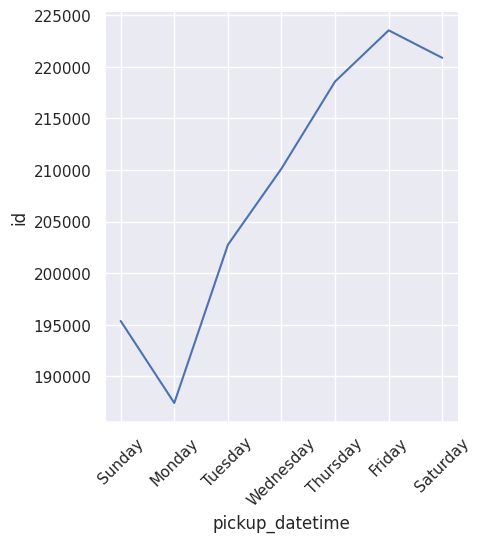

In [21]:
sns.relplot(data=w_day, x="pickup_datetime", y="id", kind="line")
plt.xticks(rotation=45)

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

Добавим колонку с месяцем.

In [22]:
train['month'] = train['pickup_datetime'].dt.strftime('%m')

Создадим датафрейм с количеством заказов в каждый час в каждый месяц.

In [23]:
months = train.groupby([train['hour'], train['pickup_datetime'].dt.month_name()]).id.count().reset_index().dropna()

И построим график.

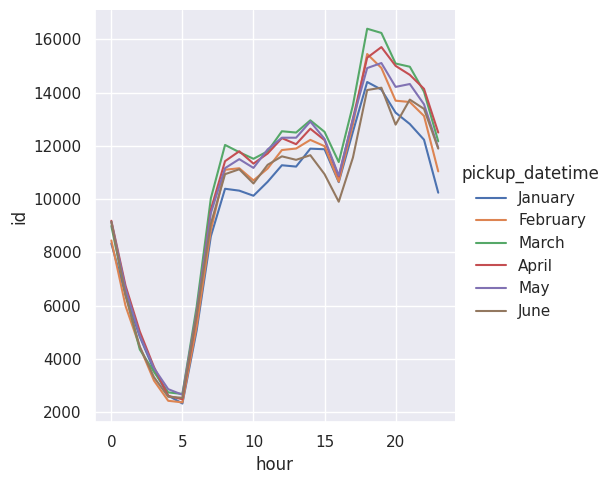

In [24]:
month_order = ["January", "February", "March", "April", "May", "June"]
sns.relplot(data=months, x="hour", y="id", hue="pickup_datetime", kind="line", hue_order=month_order)

Создадим датафрейм с количеством заказов в каждый час в каждый день недели.

In [25]:
weekdays = train.groupby([train['hour'], train['pickup_datetime'].dt.day_name()]).id.count().reset_index().dropna()

И построим график.

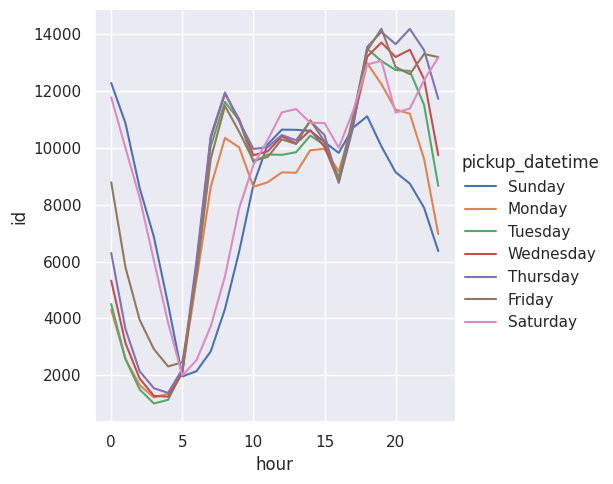

In [26]:
weekday_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
sns.relplot(data=weekdays, x="hour", y="id", hue="pickup_datetime", kind="line", hue_order=weekday_order)

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ**: Месяца. Распределение количества поездок по часам практически не отличается друг от друга в разные месяца. По ночам (до 5 утра) люди совершают приблизительно одинаковое количество по ездок в каждый месяц. После этого количество поездок практически стабильно растет, имея небольшой спад в районе 17 часов, а потом снова набирая , падая к вечеру. При этом, в час-пик поездок больше всего совершается в марте, а меньше всего - в январе и июне.

Дни недели. Распределение по дням недели в большинстве случаев похоже на распределение по месяцам. Тем не менее выходные дни довольно сильно выделяются. Количество поездок в ночное время - больше, чем в будни, в час-пик - меньше. В субботу к вечеру количество поездок растет, а в воскресенье - падает (что типично для других дней недели).

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

Импортируем train_test_split.

In [27]:
from sklearn.model_selection import train_test_split

Перемешиваем строки и разбиваем выборку. Здесь я добавлю параметр random_state, чтобы потом можно было добавлять признаки к train, делить выборку и получать те же самые X_train (чтобы не добавлять новые признаки отдельно к X_test и X_train).



In [28]:
y = train['log_trip_duration']
X = train.drop('log_trip_duration',axis=1)

X_train, X_test, y_train, y_test = train_test_split(
  X,y,test_size=0.3, shuffle=True, random_state=42)

Теперь построим график зависимости среднего логарифма времени поездки от дня недели.

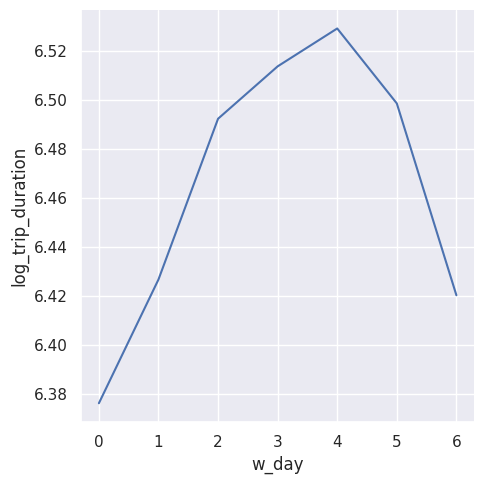

In [29]:
w_day_train = pd.DataFrame({'w_day': X_train['w_day'], 'log_trip_duration': y_train})
w_day_train = w_day_train.groupby('w_day')['log_trip_duration'].mean().reset_index()
sns.relplot(data=w_day_train, x='w_day', y='log_trip_duration', kind="line")

Для часа в сутках.

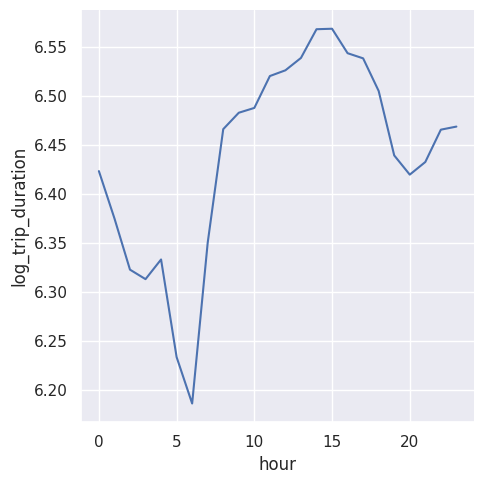

In [30]:
hour_train = pd.DataFrame({'hour': X_train['hour'], 'log_trip_duration': y_train})
hour_train = hour_train.groupby('hour')['log_trip_duration'].mean().reset_index()
sns.relplot(data=hour_train, x='hour', y='log_trip_duration', kind="line")

Для дня в году.

(array([16801., 16832., 16861., 16892., 16922., 16953., 16983.]),
 [Text(16801.0, 0, '2016-01'),
  Text(16832.0, 0, '2016-02'),
  Text(16861.0, 0, '2016-03'),
  Text(16892.0, 0, '2016-04'),
  Text(16922.0, 0, '2016-05'),
  Text(16953.0, 0, '2016-06'),
  Text(16983.0, 0, '2016-07')])

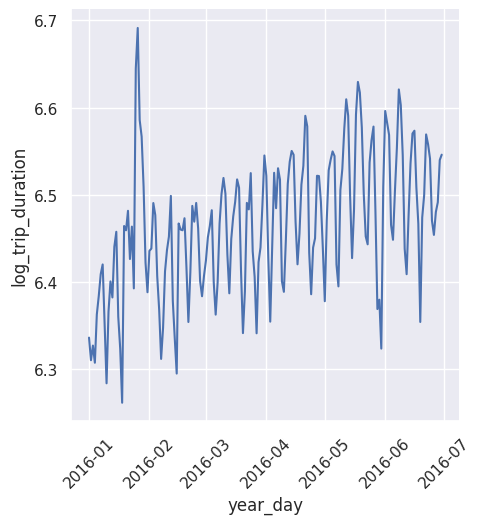

In [31]:
year_day_train = pd.DataFrame({'year_day': X_train['pickup_datetime'].dt.date, 'log_trip_duration': y_train})
year_day_train = year_day_train.groupby('year_day')['log_trip_duration'].mean().reset_index()
sns.relplot(data=year_day_train, x='year_day', y='log_trip_duration', kind="line")
plt.xticks(rotation=45)

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Удивительно, от дня недели и от часа - похожи! Это может быть связано, например, с тем, что когда поездок много, на дорогах становится много машин, соответстенно увеличивается и длительность поездок из-за пробок. Е

В аномальные периоды мы видим скачок log_trip_duration вверх. Наверное, в те дни люди ездили только по очень важным делам, когда нельзя было обойтись без такси, скорее всего, на длинные расстояния.

Тренд есть. С течением времени линия регрессии (среднее) растет, при этом сам таргет постоянно колеблется возле этой прямой.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

Добавим их сначала к X_train (остальные мы уже добавили).

In [32]:
X_train['anomal1'] = X_train.pickup_datetime.dt.date.apply(lambda x: 1 if (x == '2016-01-23' or x == '2016-01-24') else 0)
X_train['anomal2'] = X_train.pickup_datetime.dt.date.apply(lambda x: 1 if x == '2016-05-30' else 0)
X_train['day_number'] = X_train['pickup_datetime'].dt.strftime('%j').astype(int)

А теперь - к X_test.

In [33]:
X_test['anomal1'] = X_test.pickup_datetime.dt.date.apply(lambda x: 1 if (x == '2016-01-23' or x == '2016-01-24') else 0)
X_test['anomal2'] = X_test.pickup_datetime.dt.date.apply(lambda x: 1 if x == '2016-05-30' else 0)
X_test['day_number'] = X_test['pickup_datetime'].dt.strftime('%j').astype(int)

К train тоже добавим на будущее.

In [34]:
train['anomal1'] = train.pickup_datetime.dt.date.apply(lambda x: 1 if (x == '2016-01-23' or x == '2016-01-24') else 0)
train['anomal2'] = train.pickup_datetime.dt.date.apply(lambda x: 1 if x == '2016-05-30' else 0)
train['day_number'] = train['pickup_datetime'].dt.strftime('%j').astype(int)

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

**Ответ**: Количественные признаки подразумевают, что их значения можно между собой сравнивать. Мы не можем сказать, что, например, январь меньше, чем март. При этом нужно учитывать, что 23 часа и 0 часов близки друг к другу, но если сделать признак времени количественным, это сделать не получится. По этому принципу категориальными будут vendor_id, store_and_fwd_flag, hour, w_day, anomal1, anomal2. Остальные будут количественными.

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

categorical = ['w_day', 'hour', 'anomal1', 'anomal2']
numeric_features = ['month', 'day_number']

X_train_selected = X_train[categorical + numeric_features]
X_test_selected = X_test[categorical + numeric_features]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Test RMSLE = 0.7883


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [36]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [37]:
show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [38]:
show_circles_on_map(train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

Выделяются скопления точек в аэропортах JFK и LaGuardia, поскольку они находятся на большом расстоянии от Манхэттена, при этом точек там довольно много. При вычислении длительности поездки важно будет отдельно обработать эти объекты, потому что ехать до них дольше чем до большинства других.

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [39]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

train.loc[:, 'haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [40]:
train['log_haversine'] = np.log1p(train['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [41]:
your_df = train
assert your_df['log_haversine'].corr(your_df['log_trip_duration']) > your_df['haversine'].corr(your_df['log_trip_duration'])

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

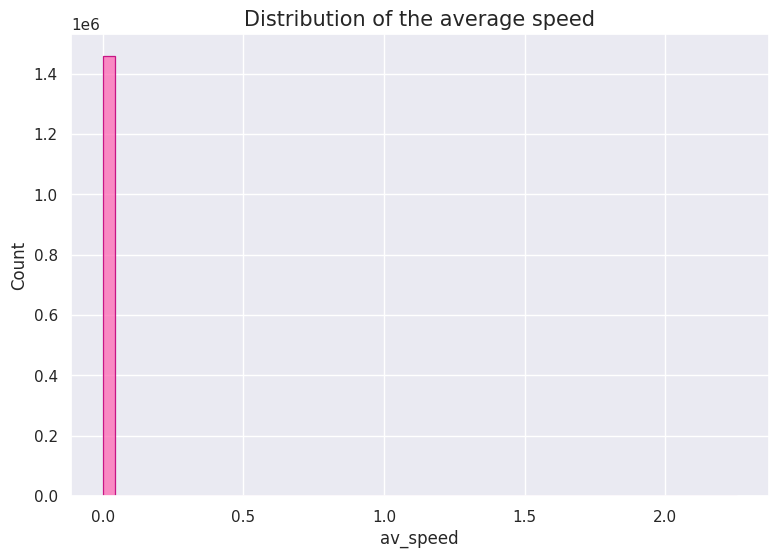

In [42]:
train['av_speed'] = train['haversine']/np.exp(train['log_trip_duration'])
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_title('Distribution of the average speed', fontsize=15)
sns.histplot(train['av_speed'],
             bins=50,
             ax=ax,
             color='hotpink',
             edgecolor='mediumvioletred');

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

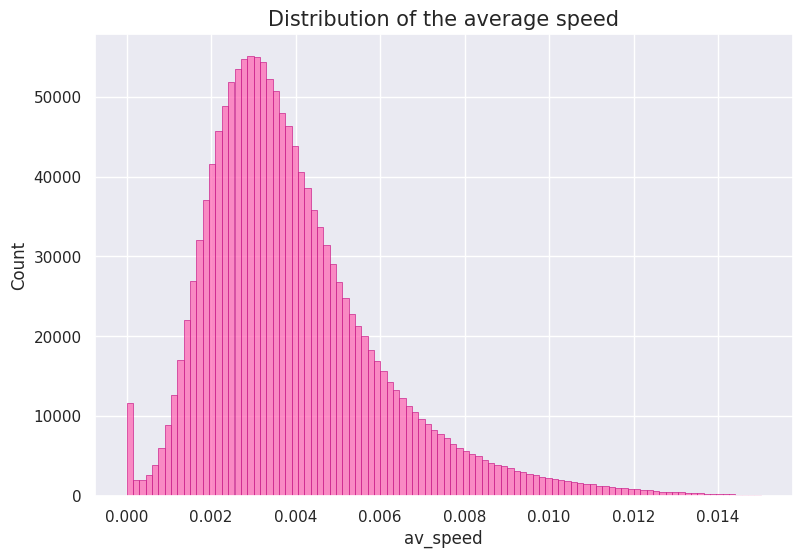

In [43]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_title('Distribution of the average speed', fontsize=15)
sns.histplot(train['av_speed'][train['av_speed'] < train['av_speed'].quantile(0.999)],
             bins=100,
             ax=ax,
             color='hotpink',
             edgecolor='mediumvioletred');

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [44]:
medians = train.groupby(['hour', 'w_day'])['av_speed'].median().reset_index().dropna()

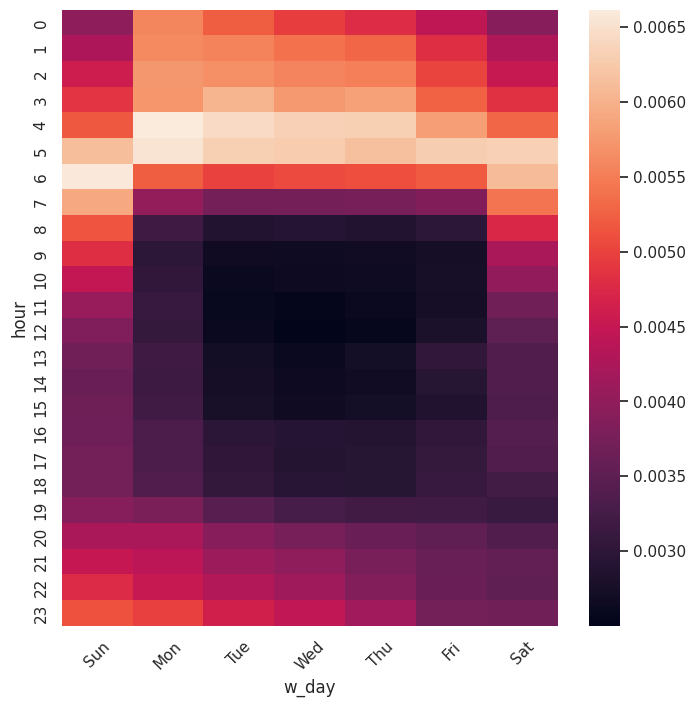

In [45]:
fig, ax = plt.subplots(figsize=(8,8))
pivot = medians.pivot_table(index="hour", columns="w_day", values="av_speed").fillna(0)
ordered_days = ['0', '1', '2', '3', '4', '5', '6']
pivot = pivot[ordered_days]
sns.heatmap(pivot, ax=ax)
days_of_week = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
ax.set_xticklabels(days_of_week, rotation=45)
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [46]:
train = train.drop(['av_speed'], axis = 1)

Если использовать этот признак, то произойдет утечка данных, поскольку длительность поездки = расстояние / скорость, то есть из двух колонок мы сможем напрямую получить нужный результат.

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [47]:
train['w_day'] = train['pickup_datetime'].dt.strftime('%w')

In [48]:
train['trafficjam'] = train.apply(
    lambda row: 1 if (8 <= row['pickup_datetime'].hour <= 19 and row['w_day'] in ["1", "2", "3", "4", "5"]) or
    (19 <= row['pickup_datetime'].hour <= 23 and row['w_day'] in ["5", "6"]) else 0, axis=1
)

train['freeroads'] = train.apply(
    lambda row: 1 if (0 <= row['pickup_datetime'].hour <= 5 and row['w_day'] in ["1", "2", "3", "4", "5"]) or
    (4 <= row['pickup_datetime'].hour <= 6 and row['w_day'] in ["5", "6"]) else 0, axis=1
)

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

In [49]:
train['start_airport'] = train.apply(
    lambda row: 1 if (abs(haversine_array(40.651112, -73.789263, row['pickup_longitude'], row['pickup_latitude'])) <= 2) or
    (abs(haversine_array(40.776472, -73.871648, row['pickup_longitude'], row['pickup_latitude']))) <= 2 else 0, axis = 1)

In [50]:
train['finish_airport'] = train.apply(
    lambda row: 1 if abs(haversine_array(40.651112, -73.789263, row['dropoff_longitude'], row['dropoff_latitude'])) <= 2 or
    abs(haversine_array(40.776472, -73.871648, row['dropoff_longitude'], row['dropoff_latitude'])) <= 2 else 0, axis = 1)

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

<Axes: xlabel='start_airport', ylabel='log_trip_duration'>

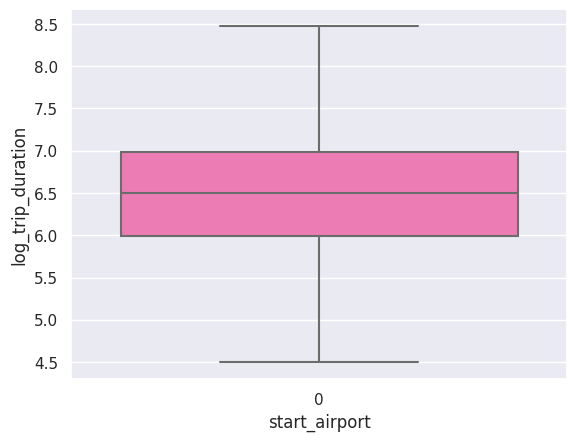

In [51]:
sns.boxplot(data = train, x="start_airport", y="log_trip_duration",  color = 'hotpink', showfliers = False)

<Axes: xlabel='finish_airport', ylabel='log_trip_duration'>

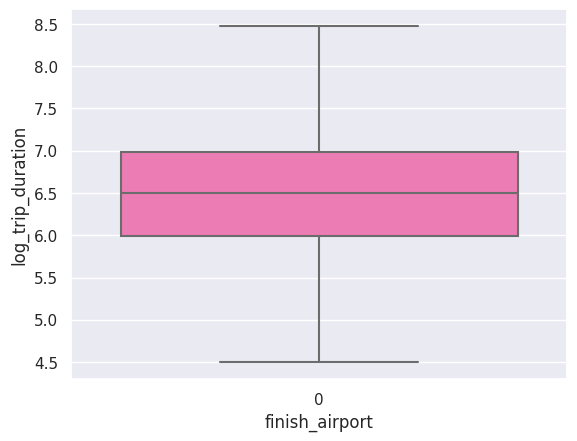

In [52]:
sns.boxplot(data = train, x="finish_airport", y="log_trip_duration", color = 'hotpink', showfliers = False)

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

Не очень, у них приблизительно такое же распределение, как и у других признаков.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_rows, n_columns):
        self.n_rows = n_rows
        self.n_columns = n_columns
        self.lst_lat = []
        self.lst_long = []

    def show_map(self):
        # you may want to visualize cells
        pass

    def fit(self, X, y=None):
        for i in range(self.n_rows + 1):
            self.lst_lat.append(X['pickup_latitude'].quantile(0.1) + i * (X['pickup_latitude'].quantile(0.9) - X['pickup_latitude'].quantile(0.1)) / self.n_rows)

        for i in range(self.n_columns + 1):
            self.lst_long.append(X['pickup_longitude'].quantile(0.1) + i * (X['pickup_longitude'].quantile(0.9) - X['pickup_longitude'].quantile(0.1)) / self.n_columns)

        return self

    def transform(self, X, y=None):
        def get_zone(lat, long):
            for i in range(self.n_rows):
                for j in range(self.n_columns):
                    if (self.lst_lat[j] <= lat <= self.lst_lat[j+1] and
                        self.lst_long[self.n_columns - i - 1] <= long <= self.lst_long[self.n_columns - i]):
                        return j + i * self.n_columns

            return -1

        X = X.copy()
        X['pickup_zone'] = X.apply(lambda row: get_zone(row['pickup_latitude'], row['pickup_longitude']), axis=1)
        X['dropoff_zone'] = X.apply(lambda row: get_zone(row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

        return X

transformer = MapGridTransformer(8, 6)
transformer.fit(train)
transformed_train = transformer.transform(train)


In [54]:
train = transformed_train

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [55]:
y = train['log_trip_duration']
X = train.drop('log_trip_duration',axis=1)

X_train, X_test, y_train, y_test = train_test_split(
  X,y,test_size=0.3, shuffle=True, random_state = 42)

In [56]:
categorical = ['w_day', 'hour', 'anomal1', 'anomal2', 'trafficjam', 'freeroads', 'start_airport', 'finish_airport', 'pickup_zone','dropoff_zone']
numeric_features = ['month', 'day_number', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','haversine', 'log_haversine']

X_train_selected = X_train[categorical + numeric_features]
X_test_selected = X_test[categorical + numeric_features]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Test RMSLE = 0.4712


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

**Ответ**: vendor_id может быть полезным, поскольку определенные люди могут пользоваться услугами определенных поставщиков. Например, в определенном районе более популярным будет одна компания, а в другом - вторая. Плюс, какие-то поставщики могут предоставлять более качественные услуги из-за стандартов компаний. Например, где-то могут принуждать более аккуратно соблюдать ПДД, что скажется на скорости движения.

passenger_count полезен тем, что днем поездки с количеством пассажиров > 1 чаще всего будут совершаться, например, с детьми. То есть путь будет лежать до мест, в которые ходят с детьми (поликлиники, развлекательные центры). По верам выходных компании могут ездить в рестораны и клубы, это тоже может повлиять на результат.

store_and_fwd_flag можетпоказывать, проезжало ли такси по тоннелям или пригородам, где плохо ловит связь. До пригородов расстояние больше.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:


In [57]:
print(f"Уникальных значений в passenger_count {len(train['passenger_count'].unique())}.\nУникальных значений в vendor_id {len(train['vendor_id'].unique())}.\nУникальных значений в store_and_fwd_flag {len(train['store_and_fwd_flag'].unique())}.")

Уникальных значений в passenger_count 10.
Уникальных значений в vendor_id 2.
Уникальных значений в store_and_fwd_flag 2.


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

<Axes: xlabel='passenger_count', ylabel='log_trip_duration'>

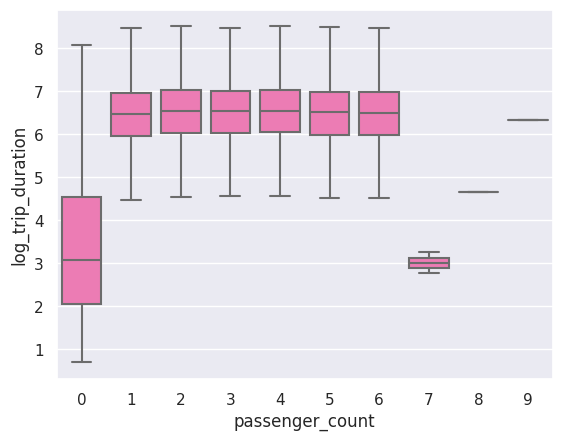

In [58]:
sns.boxplot(data = train, x="passenger_count", y="log_trip_duration", color = 'hotpink', showfliers = False)

<Axes: xlabel='vendor_id', ylabel='log_trip_duration'>

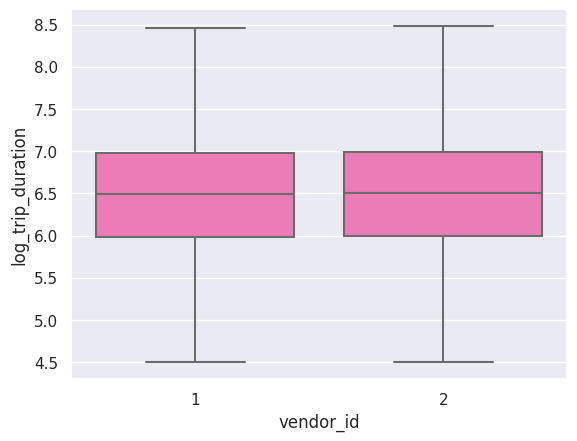

In [59]:
sns.boxplot(data = train, x="vendor_id", y="log_trip_duration", color = 'hotpink', showfliers = False)

<Axes: xlabel='store_and_fwd_flag', ylabel='log_trip_duration'>

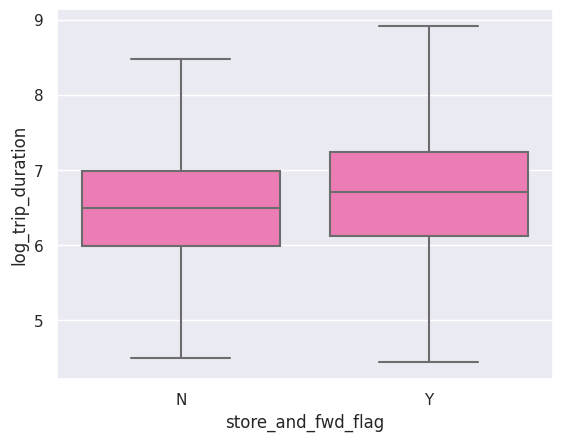

In [60]:
sns.boxplot(data = train, x="store_and_fwd_flag", y="log_trip_duration", color = 'hotpink', showfliers = False)

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [61]:
train['vendor_id'] = train['vendor_id'].replace(2, 0)
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].replace('N', 0)
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].replace('Y', 1)

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

Признак vendor_id практически бесполезен - при всех его значениях распределение значения log_trip_duration одинаковое.

passenger_count интересен тем, что при его нулевом значении (как я понимаю, это значит, что пассажир 1) распределение довольно сильно отличается от остальных. При его значении от 1 до 6 тоже почти бесполезен. Значение, большее 6 - очень редкий случай.

store_and_fwd_flag показывает небольшую разницу, но тоже почти не влияет на результат.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [62]:
categorical = ['w_day', 'hour', 'anomal1', 'anomal2', 'trafficjam', 'freeroads', 'start_airport', 'finish_airport', 'pickup_zone','dropoff_zone', 'vendor_id', 'store_and_fwd_flag', 'passenger_count']
numeric_features = ['month', 'day_number', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','haversine', 'log_haversine']

X_train_selected = X_train[categorical + numeric_features]
X_test_selected = X_test[categorical + numeric_features]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Test RMSLE = 0.4708


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

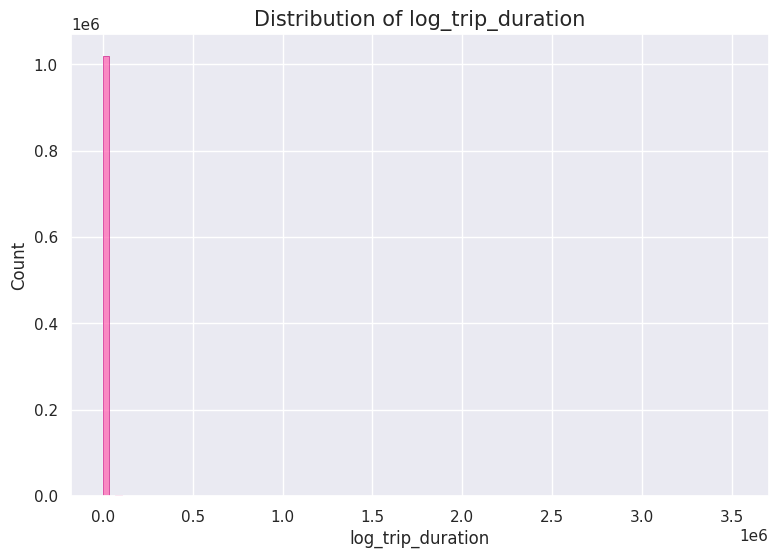

In [63]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_title('Distribution of log_trip_duration', fontsize=15)
sns.histplot(np.exp(y_train),
             bins=100,
             ax=ax,
             color='hotpink',
             edgecolor='mediumvioletred');

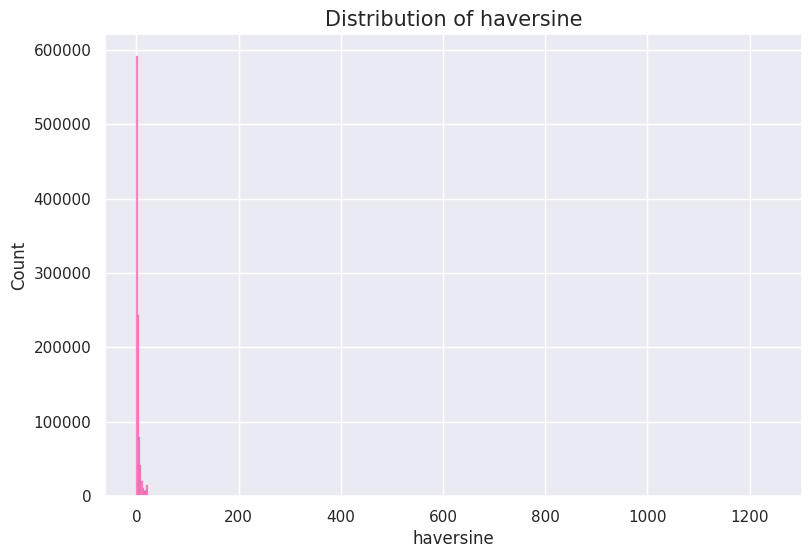

In [64]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_title('Distribution of haversine', fontsize=15)
sns.histplot(X_train['haversine'],
             bins=500,
             ax=ax,
             color='hotpink',
             edgecolor='mediumvioletred');

Text(0.5, 0, 'Residual')

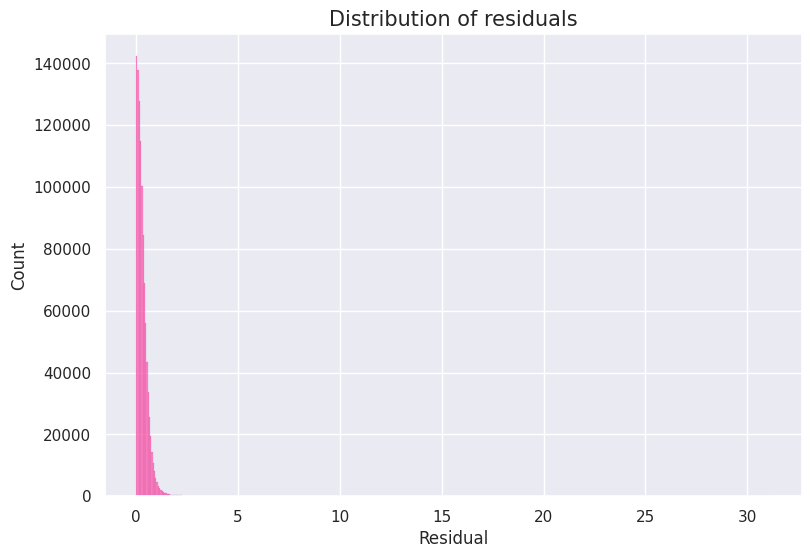

In [65]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_title('Distribution of residuals', fontsize=15)
sns.histplot(np.sqrt(np.square(model.predict(X_train) - y_train)),
             bins=500,
             ax=ax,
             color='hotpink',
             edgecolor='mediumvioletred');
ax.set_xlabel('Residual')

In [66]:
error = np.square(y_train - model.predict(X_train))
mask = (
    (error < np.quantile(error, 0.95)) &
    (np.exp(y_train) < np.quantile(np.exp(y_train), 0.95)) &
    (np.exp(X_train['log_haversine']) < np.quantile(np.exp(X_train['log_haversine']), 0.95))
)
X_train = X_train[mask]
y_train = y_train[mask]


Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [67]:
X_train['w_day'].value_counts() / len(X_train)

6    0.153791
5    0.152927
4    0.148319
3    0.143158
2    0.139267
0    0.134401
1    0.128138
Name: w_day, dtype: float64

In [68]:
X_train['hour'].value_counts() / len(X_train)

19    0.063689
18    0.062850
21    0.059244
20    0.059201
22    0.056312
17    0.051325
14    0.049504
12    0.049209
13    0.048115
23    0.047836
15    0.047439
11    0.046747
8     0.046587
9     0.046465
10    0.044785
16    0.041960
7     0.038347
0     0.036926
1     0.026801
6     0.022771
2     0.019662
3     0.014453
4     0.010253
5     0.009522
Name: hour, dtype: float64

In [69]:
X_train['pickup_zone'].value_counts() / len(X_train)

-1     0.435937
 17    0.041094
 27    0.040828
 28    0.039350
 16    0.038254
 23    0.037251
 22    0.031057
 21    0.030918
 26    0.029942
 11    0.026597
 25    0.025503
 29    0.023035
 24    0.021150
 32    0.021012
 20    0.020431
 31    0.019614
 30    0.019303
 33    0.016235
 15    0.014713
 19    0.013965
 10    0.011359
 34    0.011106
 18    0.009055
 35    0.008423
 5     0.007742
 14    0.003441
 13    0.001204
 3     0.000358
 0     0.000336
 1     0.000285
 12    0.000280
 2     0.000117
 9     0.000061
 4     0.000026
 6     0.000019
Name: pickup_zone, dtype: float64

In [70]:
X_train['dropoff_zone'].value_counts() / len(X_train)

-1     0.488503
 17    0.038293
 16    0.036788
 23    0.035630
 27    0.035360
 22    0.032380
 28    0.029654
 21    0.027469
 26    0.025054
 11    0.021301
 25    0.020471
 20    0.019309
 29    0.018603
 30    0.016296
 24    0.016194
 15    0.016162
 32    0.015979
 31    0.015894
 33    0.014499
 19    0.012363
 34    0.011141
 10    0.010734
 35    0.010348
 18    0.010224
 5     0.008577
 14    0.005228
 13    0.002271
 3     0.001426
 1     0.001181
 12    0.001122
 0     0.000859
 2     0.000462
 6     0.000130
 9     0.000058
 4     0.000036
 8     0.000002
 7     0.000002
Name: dropoff_zone, dtype: float64

In [71]:
X_train['passenger_count'].value_counts() / len(X_train)

1    0.710480
2    0.143235
5    0.053217
3    0.040970
6    0.032953
4    0.019136
0    0.000010
Name: passenger_count, dtype: float64

Так, из редких категорий можно выделить зоны в dropoff_zone и pickup_zone, часы 4, 5 в 'hour'.

In [72]:
value_counts = X_train['dropoff_zone'].value_counts(normalize=True)
rare_values = value_counts[value_counts < 0.01].index
mean_value = X_train['dropoff_zone'].mean()
X_train.loc[X_train['dropoff_zone'].isin(rare_values), 'dropoff_zone'] = mean_value

In [73]:
value_counts = X_train['pickup_zone'].value_counts(normalize=True)
rare_values = value_counts[value_counts < 0.01].index
mean_value = X_train['pickup_zone'].mean()
X_train.loc[X_train['pickup_zone'].isin(rare_values), 'pickup_zone'] = mean_value

In [74]:
X_train['hour'] = X_train['hour'].replace([4, 5], 4)

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [75]:
categorical = ['w_day', 'hour', 'anomal1', 'anomal2', 'trafficjam', 'freeroads', 'start_airport', 'finish_airport', 'pickup_zone','dropoff_zone', 'vendor_id', 'store_and_fwd_flag', 'passenger_count']
numeric_features = ['month', 'day_number', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','haversine', 'log_haversine']

X_train_selected = X_train[categorical + numeric_features]
X_test_selected = X_test[categorical + numeric_features]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Test RMSLE = 0.5265


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

Посчитаем количество признаков после OHE:

In [76]:
len(column_transformer.named_transformers_['ohe'].get_feature_names_out()) + len(numeric_features)

105

И до OHE:

In [77]:
len(categorical) + len(numeric_features)

21

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [78]:
from sklearn.linear_model import Lasso

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Test RMSLE = 0.7977


Ridge лучше)))

Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [79]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(
  X_train,y_train,test_size=0.2, shuffle=True)

In [80]:
from sklearn.model_selection import GridSearchCV

In [81]:
from sklearn.metrics import make_scorer

In [82]:
rmsle_scorer = make_scorer(
    rmsle,
    greater_is_better=False
)

In [83]:
alphas = np.logspace(-4, 1, 5)

ridge_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

ridge_searcher = GridSearchCV(
    ridge_pipeline,
    {'regression__alpha': alphas},
    scoring=rmsle_scorer,
    cv=10
)

ridge_searcher.fit(X_train_val, y_train_val)
best_alpha_ridge = ridge_searcher.best_params_['regression__alpha']

In [84]:
best_alpha_ridge

10.0

In [85]:
categorical = ['w_day', 'hour', 'anomal1', 'anomal2', 'trafficjam', 'freeroads', 'start_airport', 'finish_airport', 'pickup_zone','dropoff_zone', 'vendor_id', 'store_and_fwd_flag', 'passenger_count']
numeric_features = ['month', 'day_number', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','haversine', 'log_haversine']

X_train_selected = X_train[categorical + numeric_features]
X_test_selected = X_test[categorical + numeric_features]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])

model = pipeline.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Test RMSLE = 0.5264


In [86]:
alphas = np.logspace(-4, 1, 5)
lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

lasso_searcher = GridSearchCV(
    lasso_pipeline,
    {'regression__alpha': alphas},
    scoring=rmsle_scorer,
    cv=10
)

lasso_searcher.fit(X_train_val, y_train_val)
best_alpha_lasso = lasso_searcher.best_params_['regression__alpha']

In [87]:
best_alpha_lasso

0.0001

In [88]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha_lasso))
])

model = lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Test RMSLE = 0.5254


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [89]:
zeros = []
mses = []
for alpha in alphas:
    lasso_pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', Lasso(alpha=alpha))
    ])

    model = lasso_pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    coefficients = model.named_steps['regression'].coef_

    count = sum(1 for coef in coefficients if coef == 0)
    zeros.append(count)
    mse = rmsle(y_test, y_pred)
    mses.append(mse)

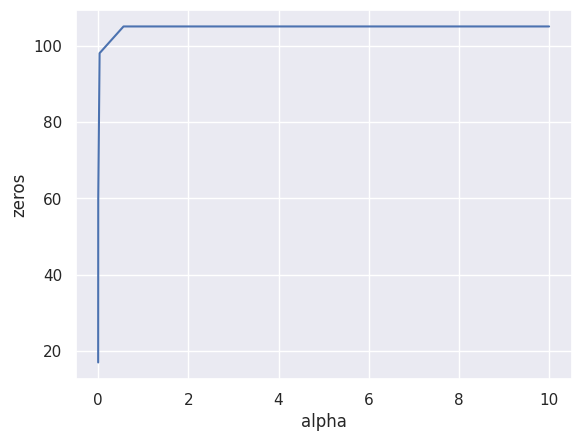

In [90]:
plt.plot(alphas, zeros)
plt.xscale("linear")
plt.xlabel("alpha")
plt.ylabel("zeros")
plt.show()

Или в логарифмической шкале.

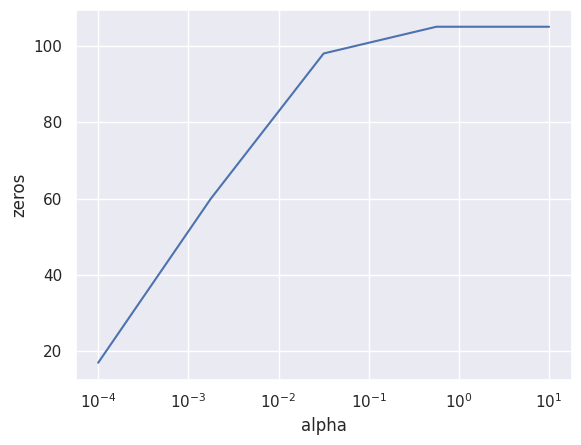

In [91]:
plt.plot(alphas, zeros)
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("zeros")
plt.show()

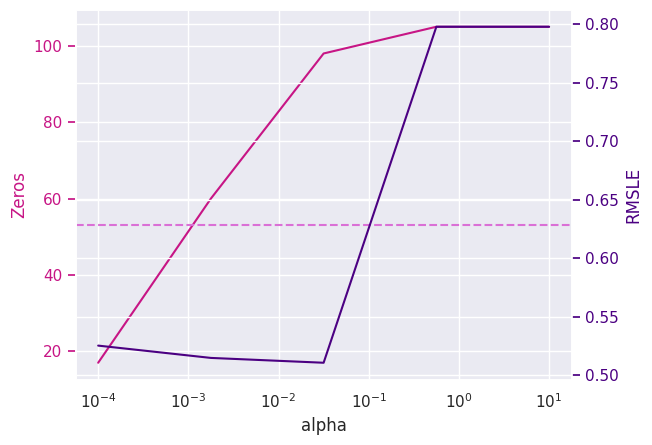

In [92]:
fig, ax1 = plt.subplots()

ax1.plot(alphas, zeros, 'mediumvioletred')
ax1.set_xscale("log")
ax1.set_xlabel('alpha')
ax1.set_ylabel('Zeros', color='mediumvioletred')
ax1.tick_params('y', colors='mediumvioletred')

ax1.axhline(53, color='orchid', linestyle='--')

ax2 = ax1.twinx()
ax2.plot(alphas, mses, 'indigo')
ax2.set_ylabel('RMSLE', color='indigo')
ax2.tick_params('y', colors='indigo')

plt.show()

Так, чтобы избавиться от половины признаков, нужно потерять в качестве приблизительно 0.65 - 0.5254 = 0.1246. пупупу

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [93]:
popular_pairs = train.groupby(['pickup_zone', 'dropoff_zone']).size().reset_index(name='count')
top_100_pairs = popular_pairs.sort_values(by='count', ascending=False).head(100)

In [94]:
train['popular_pair'] = train.apply(lambda row: 1 if (row['pickup_zone'], row['dropoff_zone']) in top_100_pairs else 0, axis=1)

In [95]:
y = train['log_trip_duration']
X = train.drop('log_trip_duration',axis=1)

X_train, X_test, y_train, y_test = train_test_split(
  X,y,test_size=0.3, shuffle=True, random_state=42)

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

Здесь Ридж дает лучший результат.

In [96]:
categorical = ['w_day', 'hour', 'anomal1', 'anomal2', 'trafficjam', 'freeroads', 'start_airport', 'finish_airport', 'pickup_zone','dropoff_zone', 'vendor_id', 'store_and_fwd_flag', 'passenger_count', 'popular_pair']

X_train_selected = X_train[categorical + numeric_features]
X_test_selected = X_test[categorical + numeric_features]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])

model = pipeline.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Test RMSLE = 0.4708


Такой признак может быть полезен тем, что длительность поездок в одинаковых парах схожа. Также, в популярных парах будет наибольшая загруженность на дорогах.

Линейная модель не может самостоятельно вытащить эти признаки, поскольку здесь присутствует нелинейная взаимосвяь между признаками, а это для нее слишком сложно. Еще здесь есть ваимодейтсвие между признаками, которую линейная модель тоже учитывать не может. А еще это быстрее)

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

Введем систему координат, где Oy будет 5th Av., а Ox - W 49 St.
Возьмем две координаты 5th Av. [(40.731753, -73.996708), (40.803051, -73.944770)] и, решим систему равнений, чтобы узнать, каким уравнением она задается.

In [97]:
A = np.array([[40.731753, 1], [40.803051, 1]])
B = np.array([-73.996708, -73.944770])
k, b = np.linalg.solve(A, B)
print(f"longitude = {k} * latitude + {b}")

longitude = 0.7284636315181763 * latitude + -103.66830870848136


Найдем центр новой системы координат (возьмем latitude нужного перекрестка).

In [98]:
print(f'40.757908, {0.7284636315181763 * 40.757908 + -103.66830870848136}')

40.757908, -73.97765503371764


Теперь для упрощения жизни сдвинем координаты точек на координаты центра.

In [99]:
train[['new_pickup_longitude', 'new_dropoff_longitude']] = train[['pickup_longitude', 'dropoff_longitude']] + 73.97765503371764
train[['new_pickup_latitude', 'new_dropoff_latitude']] = train[['pickup_latitude', 'dropoff_latitude']] - 40.757908

Найдем угол между старым Оу и новым Оу.

In [100]:
import math
math.degrees(math.atan(-1 / 0.7284636315181763))

-53.92802330592511

Отлично, а теперь можем найти матрицу поворота.

In [101]:
turn_matrix = np.array([[math.cos(-53.92802330592511), - math.sin(-53.92802330592511)], [math.sin(-53.92802330592511), math.cos(-53.92802330592511)]])

И повернем наши координаты в надежде на то, что мы нигде не налажали...

In [102]:
train[['new_pickup_latitude', 'new_pickup_longitude']] = np.dot(turn_matrix, train[['new_pickup_latitude', 'new_pickup_longitude']].values.T).T
train[['new_dropoff_latitude', 'new_dropoff_longitude']] = np.dot(turn_matrix, train[['new_dropoff_latitude', 'new_dropoff_longitude']].values.T).T

In [103]:
train.head(1)

id  vendor_id     pickup_datetime  passenger_count  \
0  id2875421          0 2016-03-14 17:24:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937          -73.96463         40.765602   

   store_and_fwd_flag  log_trip_duration  ... freeroads  start_airport  \
0                   0           6.122493  ...         0              0   

  finish_airport pickup_zone  dropoff_zone  popular_pair  \
0              0          -1            -1             0   

   new_pickup_longitude  new_dropoff_longitude  new_pickup_latitude  \
0              0.008894              -0.007468            -0.006459   

   new_dropoff_latitude  
0             -0.013156  

[1 rows x 30 columns]

Я в шоке это сработало...
<br>Ладно значит теперь считаем манхэттенское расстояние

In [104]:
train['manhattan_distance'] = (abs(train['new_dropoff_longitude'] - train['new_pickup_longitude']) + abs(train['new_dropoff_latitude'] - train['new_pickup_latitude']))

Теперь логарифм.

In [105]:
train['log_manhattan_distance'] = np.log1p(train['manhattan_distance'])

Корреляция.

In [106]:
train['log_manhattan_distance'].corr(train['log_trip_duration'])

0.6296438112015319

In [107]:
train['manhattan_distance'].corr(train['log_trip_duration'])

0.572702308252947

In [108]:
train['log_haversine'].corr(train['log_trip_duration'])

0.7498822373942495

У log_haversine корелляция выше(

Порисуем теперь!

In [109]:
mapObj = folium.Map(location = [40.757908, -73.97765503371764], zoom_start = 13)
pathLatLngs1 = [(40.766049, -73.996911), (40.753085, -73.966195)]
pathLatLngs2 = [(40.731474,  0.7284636315181763 * 40.731474 - 103.66830870848136), (40.802963,  0.7284636315181763 * 40.802963 - 103.66830870848136)]
folium.PolyLine(pathLatLngs1, color="red", weight=3).add_to(mapObj)
folium.PolyLine(pathLatLngs2, color="red", weight=3).add_to(mapObj)

In [110]:
from google.colab import files
from IPython.display import Image

In [111]:
uploaded = files.upload()

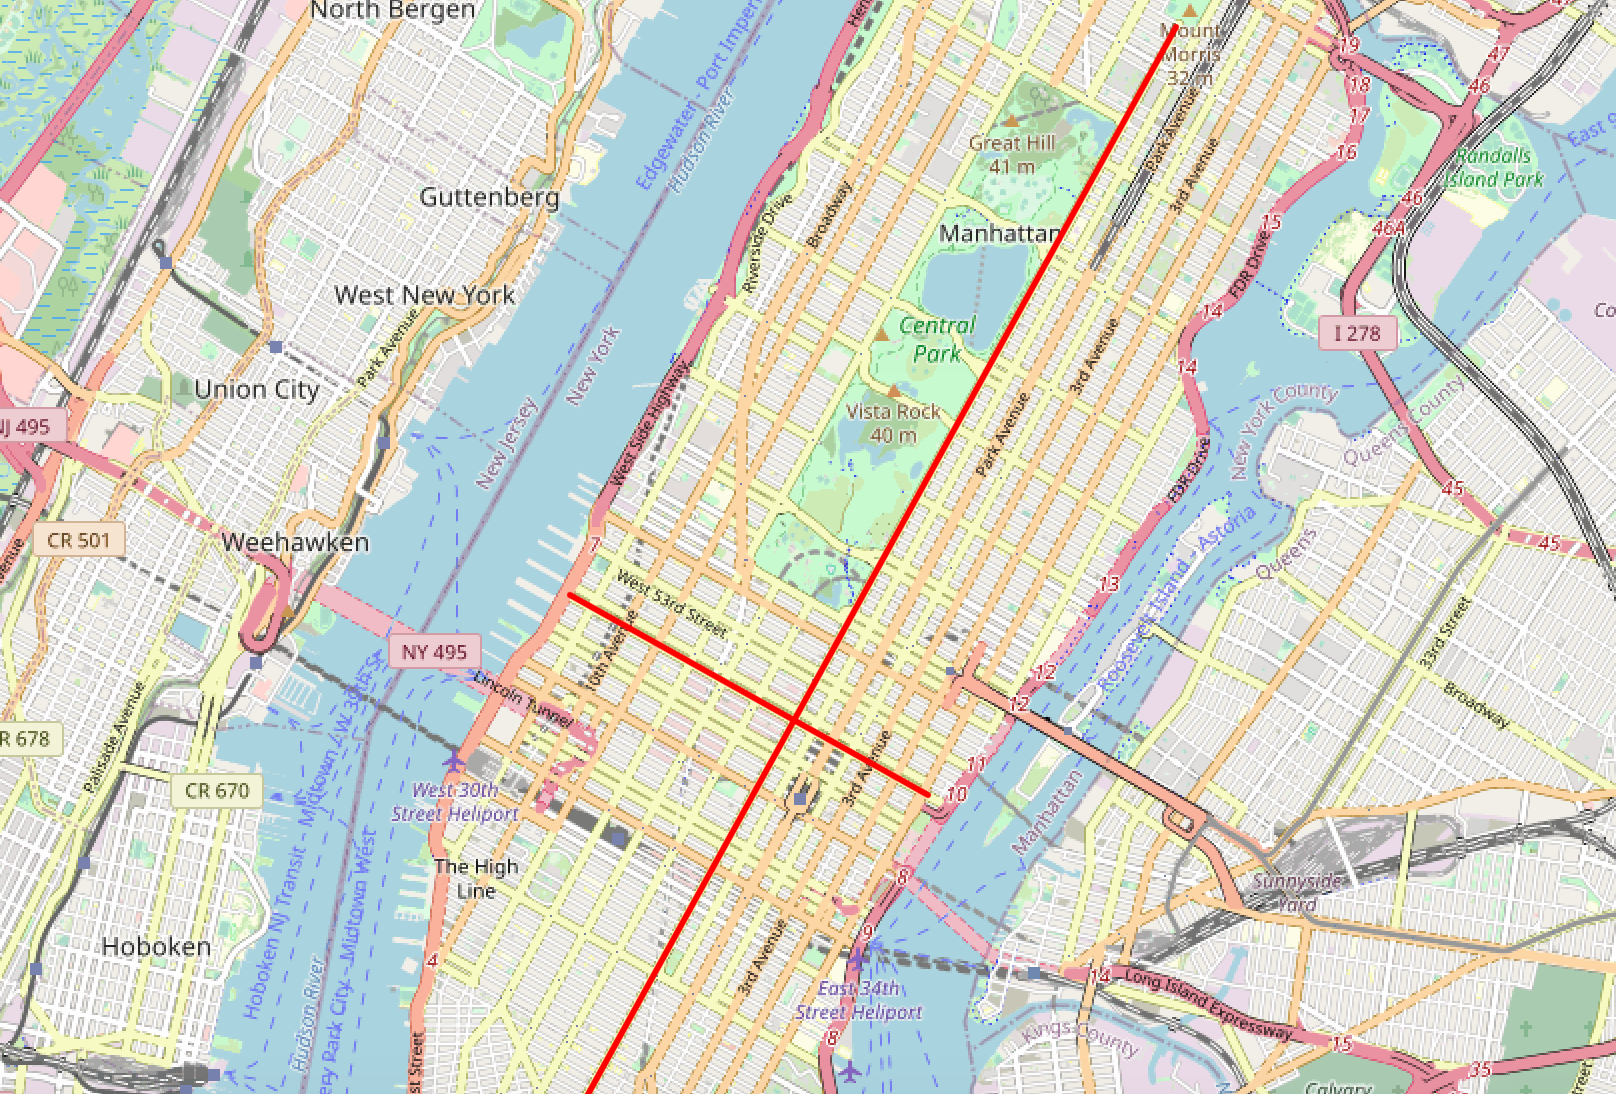

In [112]:
Image('Снимок экрана 2023-10-21 в 22.33.50.png')

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [113]:
!pip install h3

In [114]:
import h3

In [115]:
class Transformer:
    def __init__(self, df, pickup_lat_col, pickup_lon_col, dropoff_lat_col, dropoff_lon_col):
        self.df = df
        self.pickup_lat_col = pickup_lat_col
        self.pickup_lon_col = pickup_lon_col
        self.dropoff_lat_col = dropoff_lat_col
        self.dropoff_lon_col = dropoff_lon_col

    def add_h3_index(self, resolution=8):
        self.df['h3_index_pickup'] = self.df.apply(
            lambda row: h3.geo_to_h3(row[self.pickup_lat_col], row[self.pickup_lon_col], resolution), axis=1)
        self.df['h3_index_dropoff'] = self.df.apply(
            lambda row: h3.geo_to_h3(row[self.dropoff_lat_col], row[self.dropoff_lon_col], resolution), axis=1)

    def visualize_map(self, color='hotpink', fill_opacity=0.5):
        m = folium.Map(location=[self.df[self.pickup_lat_col].mean(), self.df[self.pickup_lon_col].mean()], zoom_start=13)

        def add_hexagon_to_map(map_object, hex_id, color=color, fill_opacity=fill_opacity):
            hex_boundary = list(h3.h3_to_geo_boundary(hex_id))
            hex_boundary.append(hex_boundary[0])
            folium.PolyLine(locations=hex_boundary, color=color, weight=2, fill_opacity=fill_opacity, fill=True).add_to(map_object)

        for hex_id in self.df['h3_index_pickup'].unique():
            add_hexagon_to_map(m, hex_id, color=color, fill_opacity=fill_opacity)

        return m

    def add_h3_distance(self):
        self.df['h3_distance'] = self.df.apply(
            lambda row: h3.h3_distance(row['h3_index_pickup'], row['h3_index_dropoff']), axis=1)

In [116]:
transformer = Transformer(train, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
transformer.add_h3_index()
map_object = transformer.visualize_map()
display(map_object)
transformer.add_h3_distance()
train

id  vendor_id     pickup_datetime  passenger_count  \
0        id2875421          0 2016-03-14 17:24:55                1   
1        id2377394          1 2016-06-12 00:43:35                1   
2        id3858529          0 2016-01-19 11:35:24                1   
3        id3504673          0 2016-04-06 19:32:31                1   
4        id2181028          0 2016-03-26 13:30:55                1   
...            ...        ...                 ...              ...   
1458639  id2376096          0 2016-04-08 13:31:04                4   
1458640  id1049543          1 2016-01-10 07:35:15                1   
1458641  id2304944          0 2016-04-22 06:57:41                1   
1458642  id2714485          1 2016-01-05 15:56:26                1   
1458643  id1209952          1 2016-04-05 14:44:25                1   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
0              -73.982155        40.767937         -73.964630   
1              -73.980415        40.738564         -73.999481   
2              -73.979027        40.763939         -74.005333   
3              -74.010040        40.719971         -74.012268   
4              -73.973053        40.793209         -73.972923   
...                   ...              ...                ...   
1458639        -73.982201        40.745522         -73.994911   
1458640        -74.000946        40.747379         -73.970184   
1458641        -73.959129        40.768799         -74.004433   
1458642        -73.982079        40.749062         -73.974632   
1458643        -73.979538        40.781750         -73.972809   

         dropoff_latitude  store_and_fwd_flag  log_trip_duration  ...  \
0               40.765602                   0           6.122493  ...   
1               40.731152                   0           6.498282  ...   
2               40.710087                   0           7.661527  ...   
3               40.706718                   0           6.063785  ...   
4               40.782520                   0           6.077642  ...   
...                   ...                 ...                ...  ...   
1458639         40.740170                   0           6.658011  ...   
1458640         40.796547                   0           6.486161  ...   
1458641         40.707371                   0           6.639876  ...   
1458642         40.757107                   0           5.924256  ...   
1458643         40.790585                   0           5.293305  ...   

        popular_pair  new_pickup_longitude new_dropoff_longitude  \
0                  0              0.008894             -0.007468   
1                  0             -0.007234              0.005614   
2                  0              0.004191              0.000206   
3                  0              0.009208              0.004544   
4                  0              0.013578              0.008146   
...              ...                   ...                   ...   
1458639            0             -0.002222              0.006139   
1458640            0              0.014961              0.012751   
1458641            0             -0.010648             -0.001927   
1458642            0             -0.000566             -0.003021   
1458643            0              0.013499              0.012060   

        new_pickup_latitude  new_dropoff_latitude  manhattan_distance  \
0                 -0.006459             -0.013156            0.023059   
1                  0.018152              0.034070            0.028766   
2                 -0.004548              0.055253            0.063787   
3                  0.049023              0.061626            0.017267   
4                 -0.032909             -0.023702            0.014639   
...                     ...                   ...                 ...   
1458639            0.013006              0.023974            0.019329   
1458640            0.020724             -0.037232            0.060166   
1458641           -0.018666              0.

In [117]:
y = train['log_trip_duration']
X = train.drop('log_trip_duration',axis=1)

X_train, X_test, y_train, y_test = train_test_split(
  X,y,test_size=0.3, shuffle=True, random_state=42)

In [118]:
categorical = ['w_day', 'hour', 'anomal1', 'anomal2', 'trafficjam', 'freeroads', 'start_airport', 'finish_airport', 'pickup_zone','dropoff_zone', 'vendor_id', 'store_and_fwd_flag', 'passenger_count', 'popular_pair', 'h3_distance', 'h3_index_pickup', 'h3_index_dropoff']
X_train_selected = X_train[categorical + numeric_features]
X_test_selected = X_test[categorical + numeric_features]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])

model = pipeline.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Test RMSLE = 0.4528


А было 0.4708!

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

<img src="https://media.tumblr.com/df1957ba71964075da2fb644f1fa31c4/tumblr_inline_mf8xsjiI9h1qabig0.gif"><br>
<img src="https://img.wattpad.com/e76ded6961f8d22f8840175938a3f6b370bb9021/68747470733a2f2f73332e616d617a6f6e6177732e636f6d2f776174747061642d6d656469612d736572766963652f53746f7279496d6167652f50516f7056396e544662345231413d3d2d3934373732363539342e313633313539353739376438616164373230393739363134323339342e676966" style="width: 200px">